In [50]:
import os
import sys
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statistics
import math
import json
from pprint import pprint

%matplotlib inline
warnings.filterwarnings('ignore')

In [51]:
sys.path.append(os.path.join('..', 'src'))

In [52]:
from model import timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics
from params import ProjectParameters

# define functions

In [53]:
def capture_data(folder, file, label=False):
    path = os.path.join(folder, file+'.csv')
    return pd.read_csv(path, index_col='id')

In [54]:
def load_json_results(filename):
    filepath = os.path.join(model_outputs, filename+'.json')
    with open(filepath, 'r') as file:
        return json.load(file)

# define paths

In [55]:
inputs_raw = os.path.join('..', 'data', '01_raw')
inputs_intermediate = os.path.join('..', 'data', '02_intermediate')
inputs = os.path.join('..', 'data', '03_processed')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

# capture data

In [56]:
X_train                  = capture_data(inputs, 'X_train')
X_test                   = capture_data(inputs, 'X_test')
X_train_oh               = capture_data(inputs, 'X_train_oh')
X_test_oh                = capture_data(inputs, 'X_test_oh')

y_train                  = capture_data(inputs, 'y_train', label=True)
y_test                   = capture_data(inputs, 'y_test', label=True)
# y                        = capture_data('y', label=True)

# load model

In [57]:
ml_model = 'tree_randomforest'
json_results = load_json_results(ml_model)
for key,value in json_results.items():
    model = value[ml_model]

In [58]:
params = {}
for k,v in model['best_params'].items():
    k = k[7:]
    params[k] = v
params

{'max_features': 1, 'n_estimators': 100, 'random_state': 42}

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
#transform X_train and X_test
scale = StandardScaler()

X_train_oh_scaled = scale.fit_transform(X_train_oh)
X_test_oh_scaled = scale.transform(X_test_oh)

X_train_ord_scaled = scale.fit_transform(X_train)
X_test_ord_scaled = scale.transform(X_test)

In [61]:
X_train_oh_scaled = pd.DataFrame(X_train_oh_scaled, columns = X_train_oh.columns)
X_test_oh_scaled = pd.DataFrame(X_test_oh, columns = X_test_oh.columns)

X_train_ord_scaled = pd.DataFrame(X_train, columns = X_train.columns)
X_test_ord_scaled = pd.DataFrame(X_test, columns = X_test.columns)

# Minimum size

* https://scikit-learn.org/stable/modules/learning_curve.html
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [62]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import ElasticNet

In [63]:
MODEL_SCORE = 0.927
N = X_train.shape[0]

In [64]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), tol=0.05):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, scoring=None, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                      )
    fit_times = 0
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    train_size=1
    for i, train_size in enumerate(train_sizes):
        if abs(MODEL_SCORE - test_scores_mean[i]) < tol: break
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt, train_size, test_scores_mean

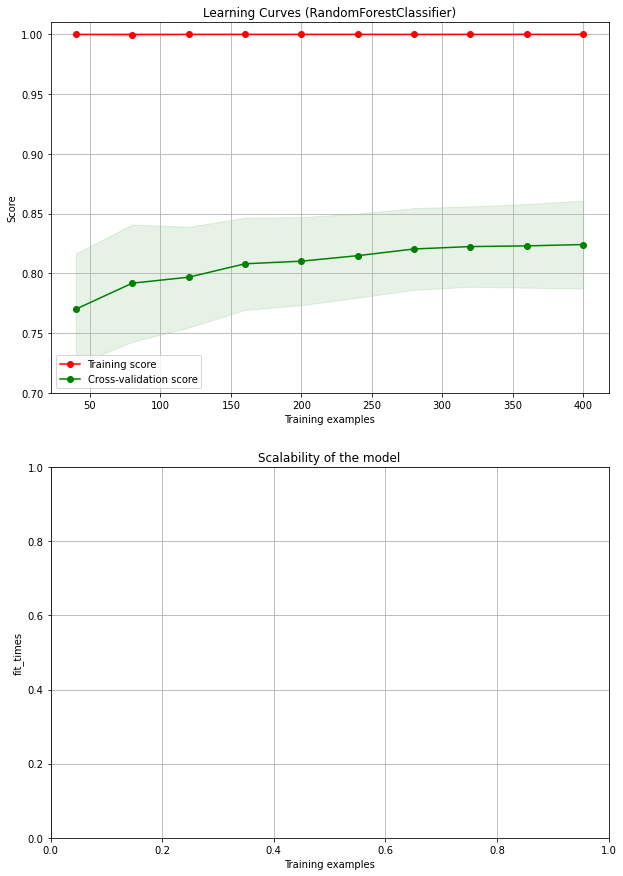

In [65]:
n_samples = 10
tol = 1e-02

fig, axes = plt.subplots(2, 1, figsize=(10, 15))

X, y = X_train_ord_scaled.head(500), y_train.head(500)

title = "Learning Curves (RandomForestClassifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features = params['max_features'], n_estimators = params['n_estimators'], 
                                         random_state = params['random_state'])
_, train_size, _2 = plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, n_samples), tol=tol)

file = 'learning_curve.png'
plt.savefig(os.path.join(reports,file), bbox_inches='tight')

# same distribution sample
If we had a huge dataset, it would be interesting to build a method to evaluate if the distributions correspond to a specific significance level. Smirnov-Kolmogorov is handy here.

Some refs:
* https://medium.com/data-science-reporter/how-to-correctly-select-a-sample-from-a-huge-dataset-in-machine-learning-24327650372c

In [66]:
from scipy import stats
from scipy.stats import ks_2samp

In [67]:
data = pd.read_csv(os.path.join(inputs_intermediate, 'data.csv'), index_col='id')
data = data[ProjectParameters().numerical_cols]
# data.drop(['address', 'tower_name', 'building_type'], axis=1, inplace=True)

In [68]:
vals_list = []
for var in data.columns:
    vals = data[var].to_list()
    vals_list.append(vals)

In [69]:
iterations = 100
significance = 0.05
size = 1000
for i in range(1, iterations+1):
    sample = data.sample(size)
    sample_indexes = sample.index
    retrieved = True
    for var in range(data.shape[1]):
        var_sample = np.array(sample.iloc[:,var])
        metrics = ks_2samp(vals_list[var], var_sample)
        pvalue = round(metrics[1], 3)
        if pvalue < significance: 
            retrieved = False
            break
    if retrieved == True: 
        print('found sample after {} iterations'.format(i) )
        break

found sample after 1 iterations


In [70]:
sample_indexes

Int64Index([16707, 28650, 25318, 12101, 27933, 21655, 28609, 18461, 25620,
            14183,
            ...
            27659,  7414, 11203,  3578,  6108, 15827,  8030, 19653,  5863,
            15252],
           dtype='int64', name='id', length=1000)